In [1]:
#enter path to MNIST modified dataset
path_to_MNIST_file = r"/home/davo/COMP551/COMP551-Project3/MNIST_synthetic.h5"

path_to_file_to_save_the_individual_digits = r'/home/davo/COMP551/COMP551-Project3/10x10_adjusted_digits_and_labels_167874instances.hdf5'

### For each image in the dataset, extract a list of digits

In [3]:
#different well performing image processing criterias and 
#the number of images on which they did NOT detect the correct number of digits
# area >7.5               ---> 55
# area >7.5 and thresh=2  ---> 42
# area >6   and thresh=2  ---> 43
# area >7.5 and thresh=1  ---> 45
# area > 4  and thresh=10 ---> 62
# area >7   and thresh=2  ---> 38

# area > 7 and thresh=2 and dividing the image if width>15 --> 4
# area > 7 and thresh=1 and dividing the image if width>15 --> 3

In [4]:
#import and function defs
import h5py
import numpy as np
import sklearn
from collections import Counter
import math
%matplotlib inline

import matplotlib.pyplot as plt
import cv2
from imutils import contours

#input: image containing digits
#output: ordered list of images containing one digit each (left to right)
def extract_digits(original):
    
    #create another image where all pixles are mapped to 0 or 1
    image = cv2.threshold(original, 1, 1, cv2.THRESH_BINARY)[1]
    #find the contours using this image
    cnts = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    #we look for contours that are big enough in the binary "thresholded image"
    digit_contours = []
    for c in cnts:
        area = cv2.contourArea(c)
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.01 * peri, True)
        x,y,w,h = cv2.boundingRect(approx)
        
        
        #only keep the countour if it's area is greater than 7
        if area > 7:                
            digit_contours.append(c)

    #if we got no contours, then just return a empty list
    if digit_contours == []:
        return []
    
    #sort the contours from left to right
    sorted_digit_contours = contours.sort_contours(digit_contours, method='left-to-right')[0]

    #retreive the section of the original image delmited by each corresponding contour in the binary image
    digits = []
    for c in sorted_digit_contours:
        x,y,w,h = cv2.boundingRect(c)
        #if the width is bigger than 15, then it's for sure 2 digits stuck together
        #I found by inspection that its almost always w=20, sometimes 19, rarely 18
        #by inspection I decided that it's best to cut it at 10 (i.e. remove the 10th column)
        #take what's to the left as ROI1, the right ROI2
        if w > 15:
            ROI_1 = original[y:y+h, x:x+10]  #x+10 excluded
            ROI_2 = original[y:y+h, x+11:x+w]
            digits.append(ROI_1)
            digits.append(ROI_2)
        else:
            ROI = original[y:y+h, x:x+w]
            digits.append(ROI)
            
    return digits

#input: list of digit images
#output: plots of the digit images
def show_digits(digits):
    n = len(digits)
    if n==0:
        print("0 digits")
    fig, axs = plt.subplots(1, n, figsize=(70, 10))
    if n==1:
        print(digits[0].shape)
        axs.imshow(digits[0])
    else:
        for d in range(n):
            axs[d].set_title(str(digits[d].shape))
            axs[d].imshow(digits[d])
    plt.tight_layout()
    
#view the original image, the corresponding labels and the extracted digits of any given index
def view_original_image_with_labels_and_extracted_digits_of_given_index(i, dataset, labels, extracted_digits_per_image):
    try:
        print(f"The labels for this image are: {labels[i]}")
    except IndexError:
        print(f"This is a test image, there are no labels associated with it")
    fig, ax = plt.subplots()
    ax.imshow(dataset[i])
    show_digits(extracted_digits_per_image[i])

    

with h5py.File(path_to_MNIST_file, 'r') as f:
    print(f'Datasets in h5 file: {list(f.keys())}')
    #train_labels is a a 2d array, each row corresponds to the digits in that image
    train_labels = np.array(f['train_labels'])

    #get the datasets and convert to numpy arrays
    #train_dataset
    train_dataset = np.array(f['train_dataset'])
    test_dataset = np.array(f['test_dataset'])
    print(f"Shape of train_dataset: {train_dataset.shape}")
    print(f"Shape of train_labels : {train_labels.shape}")
    print(f"Shape of test_dataset : {test_dataset.shape}")

#we reshape the train and test datasets to remove the 4rth dimension
train_dataset = train_dataset.reshape(56000, 64, 64)
test_dataset = test_dataset.reshape(14000, 64, 64)

Datasets in h5 file: ['test_dataset', 'train_dataset', 'train_labels']
Shape of train_dataset: (56000, 64, 64, 1)
Shape of train_labels : (56000, 5)
Shape of test_dataset : (14000, 64, 64, 1)


In [5]:
#input: train_labels, train_dataset
#output: 
#   extracted_digits_per_image = array of (lists of extracted digits for each image) 
#   true_number_of_digits_per_image = list of integers which represents the number of digits in each image
#   number_of_digits_extracted_per_image = list of integers which represents the number of digits we extracted from each image
def extract_digits_from_each_image(train_labels, train_dataset):
    #list of the true number of digits in each image
    true_number_of_digits_per_image = np.count_nonzero(-(train_labels - 10), axis=1)
    #for each number of digits, we print the true number of images with that many digits
    print(f"True # of images with corresp. # of digits: {np.unique(true_number_of_digits_per_image, return_counts=True)}")

    #for each image in the train_dataset, we create a list of it's extracted digits images
    extracted_digits_per_image = np.array([extract_digits(original) for original in train_dataset], dtype=object)

    #this is the list of the number of digits we extracted from each image
    number_of_digits_extracted_per_image = np.array(list(map(len, extracted_digits_per_image)))
    #we print the number of images with each number of extracted digits
    print(f"# of images with corresp. # of EXTRACTED digits: {np.unique(number_of_digits_extracted_per_image, return_counts=True)}")
    return extracted_digits_per_image, true_number_of_digits_per_image, number_of_digits_extracted_per_image

extracted_digits_per_image, true_number_of_digits_per_image, number_of_digits_extracted_per_image = extract_digits_from_each_image(train_labels, train_dataset)

True # of images with corresp. # of digits: (array([1, 2, 3, 4, 5]), array([11247, 11192, 11169, 11212, 11180]))
# of images with corresp. # of EXTRACTED digits: (array([1, 2, 3, 4, 5]), array([11247, 11192, 11169, 11209, 11183]))


### View an image from the dataset, it's labels and the extracted digits corresponding to it

The labels for this image are: [ 7  6  3  1 10]


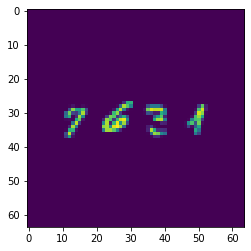

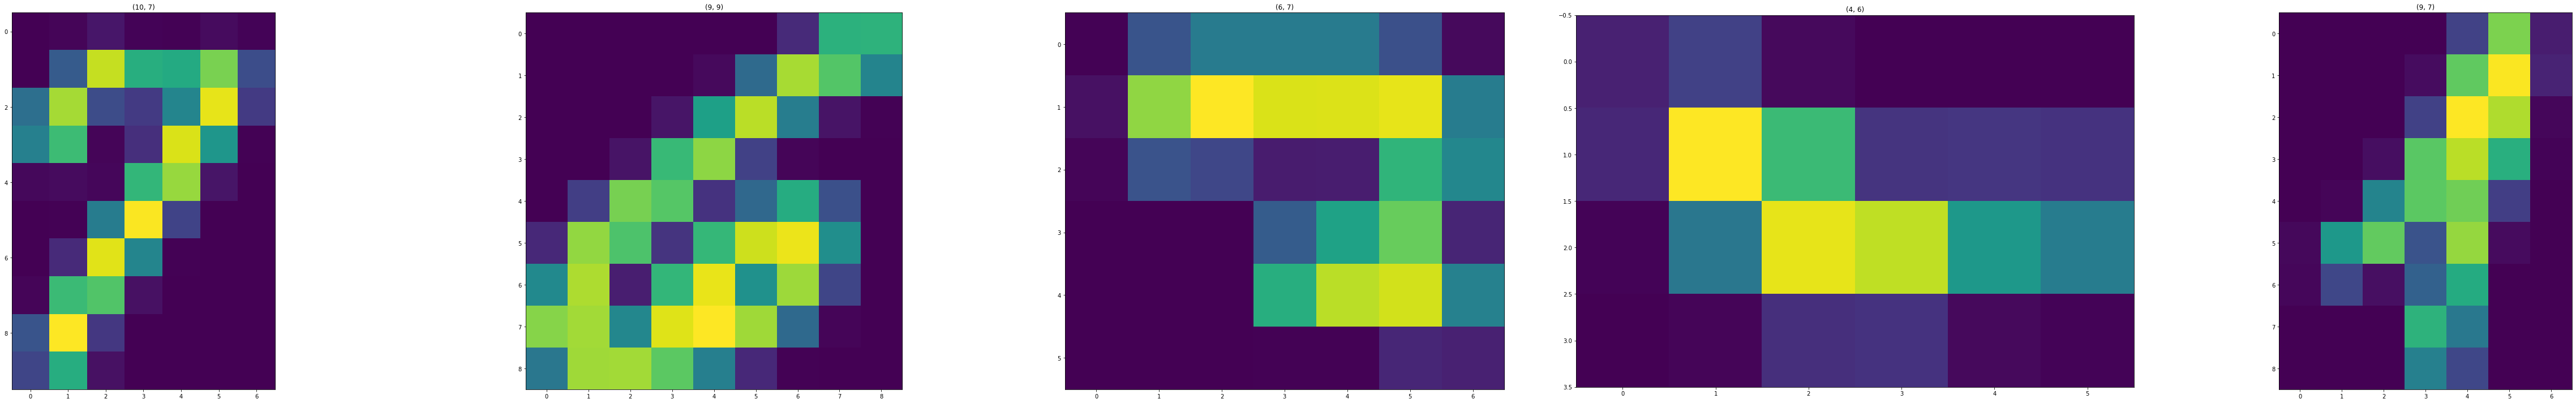

In [6]:
#image 42648 has the 3 sliced in half
view_original_image_with_labels_and_extracted_digits_of_given_index(42649, train_dataset, train_labels, extracted_digits_per_image)

### Partition the lists of digits and the labels into the ones that correspond to the images from which we extracted the correct number of digits, and the ones that don't

In [7]:
#DESCRIPTION: TO DO
def partition_dataset_and_labels_into_correctly_and_incorrectly_extracted_images(extracted_digits_per_image, train_labels, number_of_digits_extracted_per_image, true_number_of_digits_per_image):
    #get the indices of the correctly and incorrectly extracted images
    correctly_extracted_indices = np.where(number_of_digits_extracted_per_image == true_number_of_digits_per_image)[0]
    incorrectly_extracted_indices = np.where(number_of_digits_extracted_per_image != true_number_of_digits_per_image)[0]
    
    #partition the train_labels and the train_dataset into these two categories
    #extracted digits and labels of the correct images
    correct_extracted_digits_per_image = extracted_digits_per_image[correctly_extracted_indices]
    correct_extracted_train_labels = train_labels[correctly_extracted_indices]
    #extracted digits and labels of the incorrect images
    incorrect_extracted_digits_per_image = extracted_digits_per_image[incorrectly_extracted_indices]
    incorrect_extracted_train_labels = train_labels[incorrectly_extracted_indices]
    
    #just check if the lenghts of lists are the same, just in case
    if len(correct_extracted_digits_per_image) ==  len(correct_extracted_train_labels) and len(incorrect_extracted_digits_per_image) ==  len(incorrect_extracted_train_labels):
        print(f"Indices of the images in the train_dataset from which we did not extract the correct number of digits: {incorrectly_extracted_indices}")
    else:
        raise ValueError("The above two lists don't have the same length")
        
    return (correct_extracted_digits_per_image, correct_extracted_train_labels,
            incorrect_extracted_digits_per_image, incorrect_extracted_train_labels)
    
(correct_extracted_digits_per_image, correct_extracted_train_labels, incorrect_extracted_digits_per_image, incorrect_extracted_train_labels) = partition_dataset_and_labels_into_correctly_and_incorrectly_extracted_images(extracted_digits_per_image, train_labels, number_of_digits_extracted_per_image, true_number_of_digits_per_image)

Indices of the images in the train_dataset from which we did not extract the correct number of digits: [22884 37873 42649]


### Remove the 10's and make 1d arrays of all digits and all labels of the images from which we extracted the correct number of digits

In [8]:
#input: the extracted digits per image and train labels of the images from which we extracted the correct number of digits
#output: 
        # a list of digits (we flatten the extracted_digits..)
        # the train labels of those digits (we flatten the labels and we remove the 10's )
        #for any index i, labels[i] is the label for digits[i]
def create_training_data_and_training_labels(correct_extracted_digits_per_image, correct_extracted_train_labels):
    
    #make one long 1d array of all digits. each element is a digit's image
    digits = np.array([digit for list_of_digits in correct_extracted_digits_per_image for digit in list_of_digits], dtype=object)

    #make the corresponding long 1d array of labels
    labels_with_10s = [label for list_of_labels in correct_extracted_train_labels for label in list_of_labels]
    #remove the 10s
    labels = np.array([label for label in labels_with_10s if label != 10])
    if len(labels) == len(digits):
        print(f'Number of training instances (individual digits): {len(labels)}')
    else:
        raise ValueError("The above two lists don't have the same length")

    return digits, labels

digits, labels = create_training_data_and_training_labels(correct_extracted_digits_per_image, correct_extracted_train_labels)

Number of training instances (individual digits): 167874


### View any slice of the digits array and print the corresponding labels

[8 6 3 4 9 6 7 7 8 4 6 4 3 0 0 6 6 4 1 6]


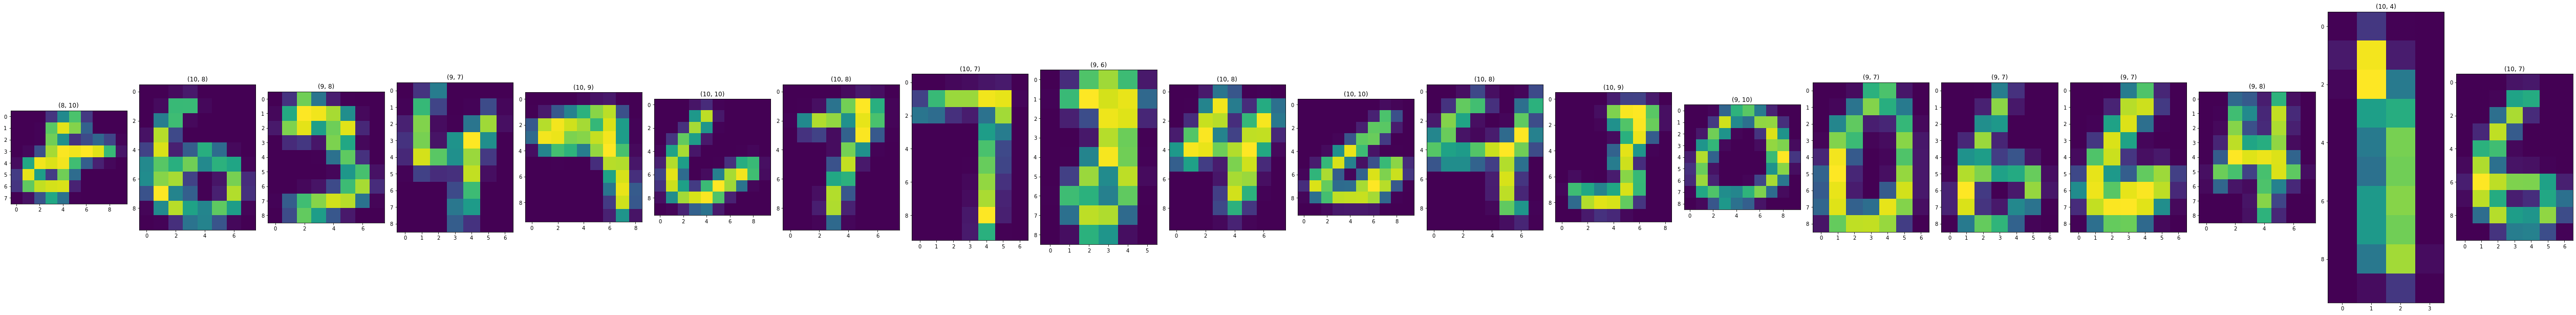

In [9]:
print(labels[102378:102398])
show_digits(digits[102378:102398])

### Analyze the shapes of these digits

In [10]:
shapes_of_digits = list(map(np.shape, digits))
Counter(shapes_of_digits).most_common()

[((10, 8), 29643),
 ((9, 8), 18419),
 ((10, 7), 18170),
 ((10, 9), 18011),
 ((9, 9), 17312),
 ((9, 7), 11442),
 ((10, 6), 10013),
 ((9, 10), 9187),
 ((10, 10), 7035),
 ((9, 6), 4875),
 ((8, 10), 3621),
 ((10, 5), 3590),
 ((8, 9), 3210),
 ((10, 3), 2897),
 ((10, 4), 2660),
 ((9, 5), 2489),
 ((9, 3), 1628),
 ((9, 4), 1271),
 ((7, 10), 796),
 ((7, 9), 543),
 ((10, 2), 404),
 ((9, 2), 271),
 ((6, 10), 160),
 ((6, 9), 94),
 ((8, 8), 47),
 ((8, 7), 23),
 ((5, 10), 20),
 ((7, 8), 14),
 ((5, 9), 10),
 ((8, 6), 6),
 ((7, 7), 6),
 ((11, 10), 3),
 ((11, 9), 3),
 ((6, 7), 1)]

In [11]:
indices_of_interest = [i for i, x in enumerate(shapes_of_digits) if x == (9, 10)]
print(indices_of_interest)

[25, 29, 32, 57, 80, 87, 103, 108, 133, 136, 138, 152, 159, 308, 333, 337, 351, 357, 397, 411, 414, 428, 436, 455, 465, 495, 531, 541, 551, 564, 575, 588, 614, 618, 631, 662, 681, 687, 689, 696, 704, 753, 783, 800, 812, 832, 840, 846, 865, 895, 923, 935, 936, 940, 948, 1029, 1049, 1069, 1078, 1090, 1105, 1114, 1117, 1124, 1126, 1141, 1142, 1144, 1171, 1187, 1228, 1237, 1251, 1292, 1299, 1322, 1385, 1416, 1424, 1536, 1552, 1564, 1588, 1593, 1629, 1634, 1642, 1653, 1692, 1698, 1739, 1747, 1751, 1771, 1774, 1820, 1837, 1847, 1878, 1902, 1903, 1924, 1949, 1951, 1963, 1967, 1975, 2002, 2004, 2025, 2027, 2048, 2061, 2063, 2079, 2089, 2099, 2107, 2117, 2159, 2160, 2161, 2173, 2177, 2182, 2192, 2196, 2204, 2213, 2231, 2251, 2255, 2265, 2290, 2367, 2385, 2405, 2422, 2437, 2453, 2461, 2465, 2484, 2488, 2494, 2495, 2508, 2522, 2536, 2541, 2546, 2548, 2589, 2605, 2617, 2650, 2661, 2668, 2693, 2699, 2762, 2769, 2781, 2787, 2800, 2805, 2808, 2809, 2819, 2830, 2847, 2853, 2863, 2870, 2896, 2913, 2930

[4 5 7 2 0 8 5 0 2 0]


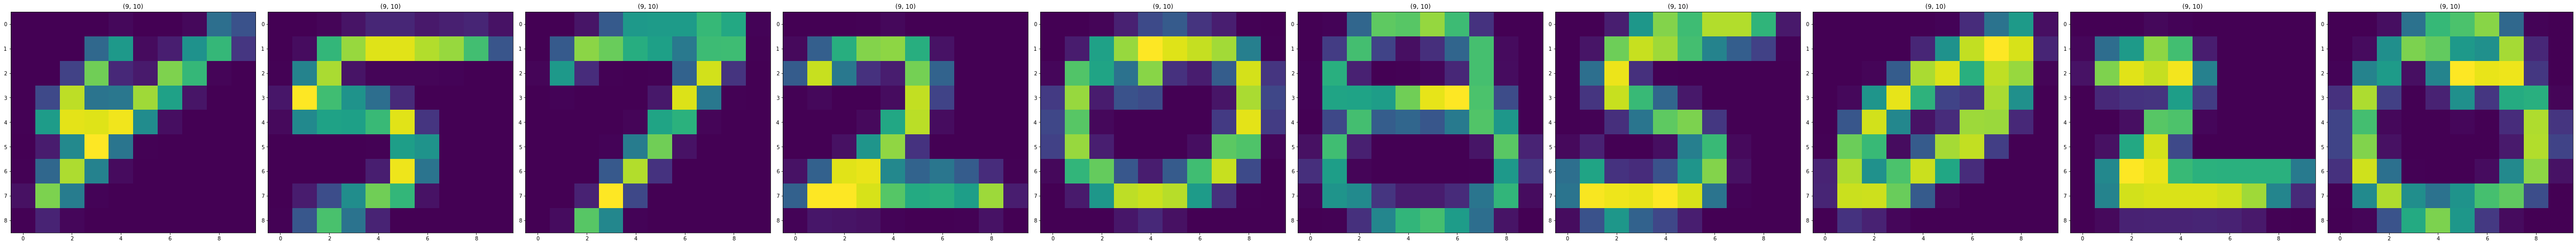

In [12]:
print(labels[indices_of_interest[10:20]])
show_digits(digits[indices_of_interest[10:20]])

### Adjust the shapes of these digits to 10X10

In [13]:
#input: digit image
#output: 10x10 version of the same image
def adjust_digit(digit):
    adjusted_digit = digit
    
    row_size, col_size = adjusted_digit.shape
    if row_size > 13 or col_size > 13:
        raise Exception("There's a digit who has more than 13 rows or columns")
    
    #add rows to top and bottom (bottom has priority)
    if row_size < 10:
        diff = 10 - row_size
        top = math.floor(diff/2)
        bottom = math.ceil(diff/2)
        adjusted_digit = np.concatenate((np.zeros((top, col_size)), adjusted_digit, np.zeros((bottom, col_size))), axis=0)
        
    #we need to take the row and col sizes again
    row_size, col_size = adjusted_digit.shape
    
    #add cols to right and left (left has priority)
    if col_size < 10:
        diff = 10 - col_size
        right = math.floor(diff/2)
        left = math.ceil(diff/2)
        adjusted_digit = np.concatenate((np.zeros((row_size, left)), adjusted_digit, np.zeros((row_size, right))), axis=1)
    
    #we return the bottom 10 rows and the leftmost 10 columns (in case the digit is bigger than 10X10) 
    return adjusted_digit[-10:, :10]

#convert all digits to 10x10
adjusted_digits = [adjust_digit(digit) for digit in digits]

#check that conversion was correct
shapes_of_adjusted_digits = list(map(np.shape, adjusted_digits))
Counter(shapes_of_adjusted_digits).most_common()

[((10, 10), 167874)]

### View any slice of the adjusted_digits array and print the corresponding labels

[8 7 4 8 2 6 6 3 8 1 9 3 4 9 4 4 7 9 8 6]


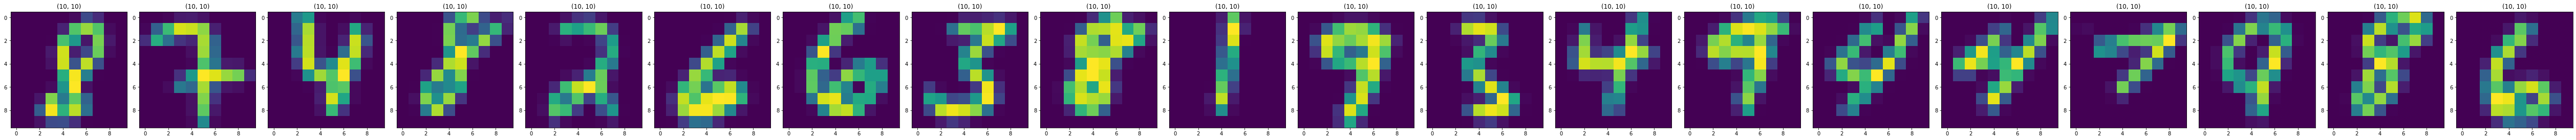

In [14]:
print(labels[-20:])
show_digits(adjusted_digits[-20:])

### Save the labels and adjusted digits for training our neural network

In [15]:
adjusted_digits = np.array(adjusted_digits)
with h5py.File(path_to_file_to_save_the_individual_digits, "w") as hf:
    hf.create_dataset("digits", data=adjusted_digits)
    hf.create_dataset("labels", data=labels)